In [117]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.fft import fft2, ifft2, fftshift, ifftshift
from torch.utils.data import DataLoader
from dataset import Galaxy_Dataset
from models.Unrolled_ADMM import Unrolled_ADMM
from utils import PSNR, estimate_shear

## LSST

### Pick a galaxy

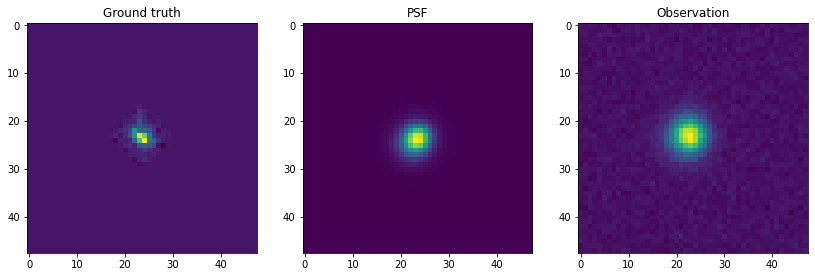

In [118]:
idx = 34
I = 23.5
data_path = 'dataset/LSST_23.5/'
psf_path = os.path.join(data_path, 'psf')
psf = torch.load(os.path.join(psf_path, f"psf_{I}_{idx}.pth"))
obs_path = os.path.join(data_path, 'obs')
obs = torch.load(os.path.join(obs_path, f"obs_{I}_{idx}.pth"))
gt_path = os.path.join(data_path, 'gt')
gt = torch.load(os.path.join(gt_path, f"gt_{I}_{idx}.pth"))

# plot
plt.figure(figsize=(14,7))
plt.subplot(1,3,1)
plt.imshow(gt)
plt.title('Ground truth')

plt.subplot(1,3,2)
plt.imshow(psf)
plt.title('PSF')

plt.subplot(1,3,3)
plt.imshow(obs)
plt.title('Observation')
plt.show()

### Fourier Power Function

In [119]:
fourier_div = ifftshift(ifft2(fft2(obs).abs() / fft2(psf).abs()).abs())

In [120]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model = Unrolled_ADMM(n_iters=8, llh='Poisson', PnP=True)
# model.to(device)

### Plot Post Stamp

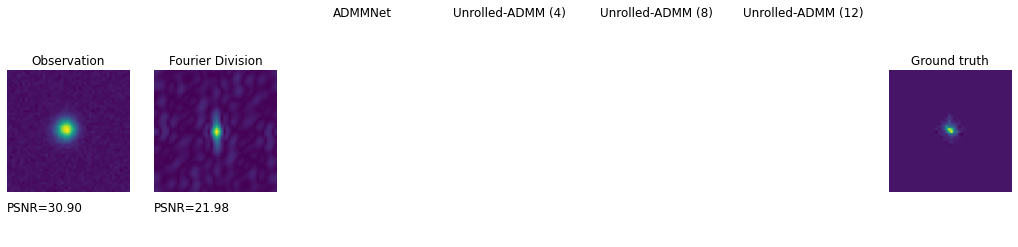

In [121]:
plt.figure(figsize=(18,4))
plt.subplot(1,7,1)
plt.imshow(obs)
plt.title("PSNR={:.2f}".format(PSNR(obs,gt)),y=-0.2,loc='left')
plt.axis('off')
plt.title('Observation')

plt.subplot(1,7,2)
plt.imshow(fourier_div)
plt.title("PSNR={:.2f}".format(PSNR(fourier_div,gt)),y=-0.2,loc='left')
plt.axis('off')
plt.title('Fourier Division')

plt.subplot(1,7,3)
# plt.imshow()
plt.axis('off')
plt.title('ADMMNet')

plt.subplot(1,7,4)
# plt.imshow()
plt.axis('off')
plt.title('Unrolled-ADMM (4)')

plt.subplot(1,7,5)
# plt.imshow()
plt.axis('off')
plt.title('Unrolled-ADMM (8)')

plt.subplot(1,7,6)
# plt.imshow()
plt.axis('off')
plt.title('Unrolled-ADMM (12)')

plt.subplot(1,7,7)
plt.imshow(gt)
plt.title('Ground truth')
plt.axis('off')
plt.show()

## JWST